# F1tenth

In [2]:
import gym
import numpy as np



## Environment playground

In [5]:
# racecar_env = gym.make(
#     'f110_gym:f110-v0',
#     map='./f1tenth_gym/gym/f110_gym/envs/maps/vegas',
#     map_ext='.png'
# )

racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png'
)

In [4]:
obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 0.], # pose of ego
             [2., 0., 0.]])  # pose of 2nd agent
) 

obs

{'ego_idx': 0,
 'scans': [array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365]),
  array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365])],
 'poses_x': [0.0, 2.0],
 'poses_y': [0.0, 0.0],
 'poses_theta': [0.0, 0.0],
 'linear_vels_x': [0.0, 0.0],
 'linear_vels_y': [0.0, 0.0],
 'ang_vels_z': [0.0, 0.0],
 'collisions': array([0., 0.]),
 'lap_times': array([0.01, 0.01]),
 'lap_counts': array([0., 0.])}

In [5]:
state = np.concatenate([
    obs['scans'][0],
    np.array(obs['linear_vels_x'][:1]),
    np.array(obs['linear_vels_y'][:1]),
])
state.shape

(1082,)

In [6]:
speeds = np.random.rand(2, 1)*2
pi_4 = 3.1415/8
pi_2 = 3.1415/4
angles = np.random.rand(2, 1)*pi_2-pi_4
actions = np.concatenate([angles, speeds], axis=1)

actions

array([[-0.0596855 ,  0.44670051],
       [-0.05675966,  1.8354974 ]])

In [2]:
## action consists of ndarray(num_agent, 2) 0: steering angle 1: velocity
## the reward function is only for the first agent

import time
import gym 
import numpy as np


racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png',
    num_agents=1
)
steps = 0

obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 1.5]]) 
) 

rewards = []

while not done:
    
    speeds = np.random.rand(2, 1)*20
    pi_4 = 3.1415/8
    pi_2 = 3.1415/4
    speeds[1][0] = 0.1
    angles = np.random.rand(2, 1)*pi_2-pi_4
    actions = np.concatenate([angles, speeds], axis=1)

    obs, step_reward, done, info = racecar_env.step(actions)
    rewards.append(step_reward)
    
    racecar_env.render()
    steps += 1
    
    if steps > 500:
        break

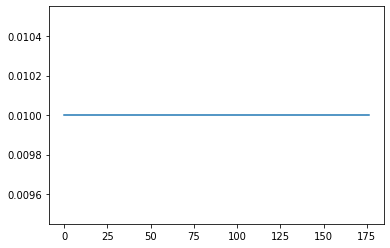

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## Define environment wrapper

### waypoints

In [ ]:
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

from numba import njit

from pyglet.gl import GL_POINTS


# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t

# @njit(fastmath=False, cache=True)
def get_actuation(pose_theta, lookahead_point, position, lookahead_distance, wheelbase):
    """
    Returns actuation
    """
    waypoint_y = np.dot(np.array([np.sin(-pose_theta), np.cos(-pose_theta)]), lookahead_point[0:2]-position)
    speed = lookahead_point[2]
    if np.abs(waypoint_y) < 1e-6:
        return speed, 0.
    radius = 1/(2.0*waypoint_y/lookahead_distance**2)
    steering_angle = np.arctan(wheelbase/radius)
    return speed, steering_angle

class PurePursuitPlanner:
    """
    Example Planner
    """
    def __init__(self, conf, wb):
        self.wheelbase = wb
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        self.drawn_waypoints = []

    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

    def render_waypoints(self, e):
        """
        update waypoints being drawn by EnvRenderer
        """

        #points = self.waypoints

        points = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        
        scaled_points = 50.*points

        for i in range(points.shape[0]):
            if len(self.drawn_waypoints) < points.shape[0]:
                b = e.batch.add(1, GL_POINTS, None, ('v3f/stream', [scaled_points[i, 0], scaled_points[i, 1], 0.]),
                                ('c3B/stream', [183, 193, 222]))
                self.drawn_waypoints.append(b)
            else:
                self.drawn_waypoints[i].vertices = [scaled_points[i, 0], scaled_points[i, 1], 0.]
        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None

    def plan(self, pose_x, pose_y, pose_theta, lookahead_distance, vgain):
        """
        gives actuation given observation
        """
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, lookahead_distance, position, pose_theta)

        if lookahead_point is None:
            return 4.0, 0.0

        speed, steering_angle = get_actuation(pose_theta, lookahead_point, position, lookahead_distance, self.wheelbase)
        speed = vgain * speed

        return speed, steering_angle

def main():
    """
    main entry point
    """

    work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}
    
    with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
        conf_dict = yaml.load(file, Loader=yaml.FullLoader)
    conf = Namespace(**conf_dict)

    planner = PurePursuitPlanner(conf, 0.17145+0.15875)

    def render_callback(env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

        planner.render_waypoints(env_renderer)

    env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
    env.add_render_callback(render_callback)
    
    obs, step_reward, done, info = env.reset(np.array([[conf.sx, conf.sy, conf.stheta]]))
    env.render()

    laptime = 0.0
    start = time.time()

    while not done:
        speed, steer = planner.plan(obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0], work['tlad'], work['vgain'])
        obs, step_reward, done, info = env.step(np.array([[steer, speed]]))
        laptime += step_reward
        env.render(mode='human')
        
    print('Sim elapsed time:', laptime, 'Real elapsed time:', time.time()-start)

main()

### waypoint handler

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace



# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t
    
    
CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)

        
        work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None
    
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):
        

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, 1.8, position, 0.9033)
        
        print(position, lookahead_point)
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        

        next_state = self.to_vector_state(obs)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



### checkpoint handler

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs][1:]
        self.t = 0
        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 0
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        buck = 3
        scanner = np.zeros(1080//buck,)
        for i in range(1080//buck):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        scanner /= 10
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'])/5,
            np.array(obs['ang_vels_z'])
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        angle = action[0]*(np.pi/4)
#         action[1] = action[1]*5
        speed = 5
        act = np.array([[angle, speed]])
#         action = np.repeat(action, repeats=2, axis=0)
#         action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
#         print(action, position)
        
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(self.t+1, position, action[0], angle)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

## Env simple wrapper

In [9]:

CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        
        self.env = gym.make(
            'f110_gym:f110-v0',
            map='./f1tenth_gym/examples/example_map',
            map_ext='.png'
        )
        
        self.reset()
        self.prev_capture_coord = None
        
    def reset(self):
        obs, step_reward, done, info = self.env.reset(
            poses=np.array([[0., 0., 0.], 
                     [-1., -1., 0.]]) 
        )
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        obs, step_reward, done, info = self.env.step(action)
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        moving_forward_rew = 0

        if self.time_to_capture == 0:
            current_coord = [obs['poses_x'][0], obs['poses_y'][0]]
            dist = abs(current_coord[0] - self.prev_capture_coord[0]) + abs(current_coord[1] - self.prev_capture_coord[1])
            # print(f"prev coord:{self.prev_capture_coord}, current_coord:{current_coord}, dist:{dist}")
            
            self.prev_capture_coord = current_coord
            if dist < 2:
                # print("Neg reward")
                moving_forward_rew = -10

            self.time_to_capture = CAPTURE_TIME + 1

        next_state = self.to_vector_state(obs)
        # ang_vel = obs['ang_vels_z'][0]
        # print(obs['ang_vels_z'][0]*0.1)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()


## Render

In [ ]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = np.array([1.0, 0.0])
    obs, reward, done, _ = env.step(action)
    env.render()

# RAY algorithms

## ppo continuous actions

### continious env

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10, map_no=4):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
#         self.low_theta = 1.1
#         self.high_theta = 2.1
#         print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        obs, step_reward, done, info = self.env.reset(np.array([[current_pos[0], current_pos[1], theta]]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):
        angle = action[0]*np.pi/4.
        speed = action[1]*5.0 + 5.0
        act = np.array([[angle, speed]])
        
#         if not self.deterministic:
#             act[0] += np.random.normal(0, 0.05, size=(2,))
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        reward = 0
#         if obs['lap_counts'][0] == 1.0:
#             done = True
#             reward = 1.0
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            done = True
            reward = -1
            
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        
        #padding from wall:
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1
            
        self.t += 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

number of waypoints:79


### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300, 300]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
print(trainer.config)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/ppo_cont_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/ppo_cont")
        print("checkpoint saved at", cp)


2022-03-08 17:45:09,459	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-08 17:45:09,460	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=39527) number of waypoints:79
(RolloutWorker pid=39527) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39508) number of waypoints:79
(RolloutWorker pid=39508) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39504) number of waypoints:79
(RolloutWorker pid=39504) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39528) number of waypoints:79
(RolloutWorker pid=39528) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39521) number of waypoints:79
(RolloutWorker pid=39521) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39520) number of waypoints:79
(RolloutWorker pid=39520) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39517) number of waypoints:79
(RolloutWorker pid=39517) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39494) number of waypoints:79
(RolloutWorker pid=39494) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=39490) number of waypoints:79
(RolloutWorker pid=39490) initi

(RolloutWorker pid=39527) 2022-03-08 17:45:23,337	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39528) 2022-03-08 17:45:23,679	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39487) 2022-03-08 17:45:23,629	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=39508) 2022-03-08 17:45:23,749	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

{'num_workers': 10, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 10000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [512, 512], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_pre

2022-03-08 17:46:06,028	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:1.6736842105263159
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000001/checkpoint-1
episode: 1 reward:1.97
episode: 2 reward:1.98
episode: 3 reward:2.25
episode: 4 reward:3.02
episode: 5 reward:3.6
episode: 6 reward:5.19
episode: 7 reward:3.64
episode: 8 reward:4.02
episode: 9 reward:6.18
episode: 10 reward:7.08
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000011/checkpoint-11
episode: 11 reward:8.21
episode: 12 reward:8.45
episode: 13 reward:10.19
episode: 14 reward:9.47
episode: 15 reward:9.17
episode: 16 reward:10.27
episode: 17 reward:11.219000000000001
episode: 18 reward:11.509
episode: 19 reward:12.109000000000002
episode: 20 reward:13.01
checkpoint saved at ./checkpoints/ppo_cont/checkpoint_000021/checkpoint-21
episode: 21 reward:13.21
episode: 22 reward:12.94


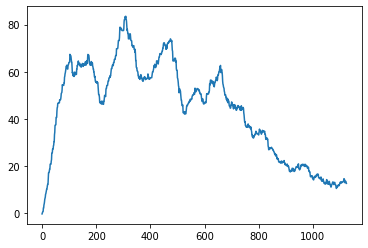

In [4]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [7]:
trainer.save("./ppo_cp_2")

'./ppo_cp_2/checkpoint_000043/checkpoint-43'

In [18]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300, 300]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_cont/checkpoint_000751/checkpoint-751')

number of waypoints:79


2022-03-14 12:33:40,729	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-03-14 12:33:40,742	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_cont/checkpoint_000751/checkpoint-751
2022-03-14 12:33:40,743	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 751, '_timesteps_total': 3755000, '_time_total': 12026.480172395706, '_episodes_total': 2561}


In [3]:
obs = env.reset()

NameError: name 'env' is not defined

In [14]:
trainer.compute_single_action(observation=obs, explore=False)

array([0.9726   , 0.9282523], dtype=float32)

In [17]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_single_action(observation=obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    


number of waypoints:79


## discrete action

### define environment

In [100]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(364,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = 5.0
        self.deterministic = deterministic
        
        self.action_map = {
            0: [0., 0.],
            1: [0., self.max_v],
            2: [-np.pi/4, self.max_v],
            3: [np.pi/4, self.max_v],
            4: [-np.pi/6, self.max_v],
            5: [np.pi/6, self.max_v],
            6: [-np.pi/4, self.max_v/2], #later
            7: [np.pi/4, self.max_v/2] #later
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map),)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        self.t = 0
        
        print(f"x and y range: {self.min_x}to{self.max_x} and {self.min_y}to{self.max_y}")
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800

        print(f"using map:{conf.map_path}")
        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None

        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        
        self.next_cp_idx = 1
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
            np.array(obs['poses_x'][:1]/(self.max_x-self.min_x)),
            np.array(obs['poses_y'][:1]/(self.max_y-self.min_y))
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(action)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({}).render()

x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard
(scheduler +6m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +6m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 30
DEFAULT_CONFIG['num_gpus'] = 2
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1
APEX_DEFAULT_CONFIG['buffer_size'] =  2000000

# trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0:
        with open('./checkpoints/ppo_disc_r2', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/ppo_disc_hard_cp2")
        print("checkpoint saved at", cp)


In [7]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


(RolloutWorker pid=1477) 2022-02-19 17:34:53,395	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1486) 2022-02-19 17:34:53,556	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1506) 2022-02-19 17:34:53,728	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1480) 2022-02-19 17:34:53,666	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBa

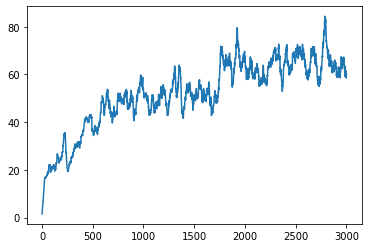

In [1]:
import pickle
import matplotlib.pyplot as plt

with open('checkpoints/ppo_disc_r2', 'rb') as f:
    l = pickle.load(f)
    
plt.plot(l)

In [3]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 0
APEX_DEFAULT_CONFIG['num_workers'] = 0
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1


trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_disc_hard_cp2/checkpoint_002701/checkpoint-2701')

2022-02-24 14:56:20,179	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-24 14:56:20,180	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


2022-02-24 14:56:20,566	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-02-24 14:56:20,568	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-02-24 14:56:20,618	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_disc_hard_cp2/checkpoint_002701/checkpoint-2701
2022-02-24 14:56:20,618	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 2701, '_timesteps_total': 21553980, '_time_total': 58813.86238908768, '_episodes_total': 9190}


In [5]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


FileNotFoundError: [Errno 2] No such file or directory: './f1tenth_gym/examples/hard.png'

In [7]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


E0224 14:46:47.268370986   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.304396184   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.368199447   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.400014867   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.421832661   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.446290439   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.623234275   13634 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 14:46:47.658036917   13634 fork_pos

(scheduler +4m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


## discrete with generalization over maps

### environment

In [7]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10.0, map_no=4):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        
        self.action_map = {
            0: [0., 0.],
            1: [0.0, self.max_v],
            2: [np.pi/4, self.max_v],
            3: [-np.pi/4, self.max_v],           
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map),)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
        self.low_theta = 1.1
        self.high_theta = 2.1
        print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        obs, step_reward, done, info = self.env.reset(np.array([[current_pos[0], current_pos[1], theta]]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
#         if not self.deterministic:
#             act[0][0] += np.random.normal(0, 0.05)
#             act[0][1] += np.random.normal(0, 2.0)
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]

        reward = 0
        
#         if obs['lap_counts'][0] == 1.0:
#             reward = 1.0
#             done = True
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1    
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

number of waypoints:79
initializing theta between: 1.1 and 2.1


### PPO 

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [200, 200]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['train_batch_size'] = 5000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
print("FINE TUNING")
trainer.restore('./checkpoints/safe_ppo/checkpoint_000101/checkpoint-101')

print(trainer.config)
rewards = []

import pickle

for i in range(1000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/safe_ppo_ft_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/safe_ppo_ft")
        print("checkpoint saved at", cp)


2022-03-11 13:32:06,153	WARNING ppo.py:223 -- `train_batch_size` (5000) cannot be achieved with your other settings (num_workers=10 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 500.


(RolloutWorker pid=506) number of waypoints:79
(RolloutWorker pid=506) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=531) number of waypoints:79
(RolloutWorker pid=531) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=516) number of waypoints:79
(RolloutWorker pid=516) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=519) number of waypoints:79
(RolloutWorker pid=519) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=525) number of waypoints:79
(RolloutWorker pid=525) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=535) number of waypoints:79
(RolloutWorker pid=535) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=533) number of waypoints:79
(RolloutWorker pid=533) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=529) number of waypoints:79
(RolloutWorker pid=529) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=530) number of waypoints:79
(RolloutWorker pid=530) initializing theta between: 1.1 and 2.1
(

(RolloutWorker pid=533) 2022-03-11 13:32:20,007	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=519) 2022-03-11 13:32:20,139	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=506) 2022-03-11 13:32:20,428	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=525) 2022-03-11 13:32:20,528	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEn

FINE TUNING
{'num_workers': 10, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 500, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 5000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [200, 200], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attentio

episode: 0 reward:10.166666666666666
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000102/checkpoint-102
episode: 1 reward:15.785714285714286
episode: 2 reward:18.333333333333332
episode: 3 reward:21.161290322580644
episode: 4 reward:22.105263157894736
episode: 5 reward:22.52173913043478
episode: 6 reward:23.346153846153847
episode: 7 reward:23.625
episode: 8 reward:24.9672131147541
episode: 9 reward:26.159420289855074
episode: 10 reward:25.613333333333333
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000112/checkpoint-112
episode: 11 reward:26.759493670886076
episode: 12 reward:26.41176470588235
episode: 13 reward:27.747252747252748
episode: 14 reward:27.96842105263158
episode: 15 reward:28.53
episode: 16 reward:29.87
episode: 17 reward:30.46
episode: 18 reward:31.49
episode: 19 reward:31.81
episode: 20 reward:31.8
checkpoint saved at ./checkpoints/safe_ppo_ft/checkpoint_000122/checkpoint-122
episode: 21 reward:32.39
episode: 22 reward:33.15
episode: 23 reward:33

In [4]:
# entropy can help I guess!
# try attention too
# padding punishment

#trainer.save('./checkpoints/ppo_gen3')

'./checkpoints/ppo_gen3/checkpoint_000040/checkpoint-40'

### rendering

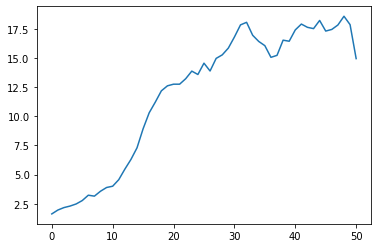

In [3]:
import matplotlib.pyplot as plt
import pickle
with open('checkpoints/ppo_gen1_r', 'rb') as f:
    rewards = pickle.load(f)
plt.plot(rewards)

In [1]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [200, 200]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/safe_ppo_ft/checkpoint_000302/checkpoint-302')
# trainer.evaluate()

ModuleNotFoundError: No module named 'ray'

In [4]:


done = False
env = F110Env({'explore':False}, deterministic=True, map_no=4, max_v=7)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/4


### deterministic action

In [7]:
done = False
env = F110Env({'explore':False}, deterministic=True, map_no=4, max_v=10)
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/4


### APEX

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG

ray.shutdown()
ray.init()


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['num_workers'] = 32
APEX_DEFAULT_CONFIG['rollout_fragment_length'] = 100
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e7)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [512, 512]
# APEX_DEFAULT_CONFIG['num_gpus_per_worker'] = 1/15
# APEX_DEFAULT_CONFIG['final_epsilon'] = 0.05
APEX_DEFAULT_CONFIG['target_network_update_freq'] = 10000
APEX_DEFAULT_CONFIG['train_batch_size'] = 256
APEX_DEFAULT_CONFIG['batch_mode'] = 'complete_episodes'

trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0 or (i<50 and i%10==0):
        with open('./checkpoints/apex_gen2_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/apex_gen2")
        print("checkpoint saved at", cp)


2022-02-25 14:39:06,824	INFO simple_q.py:153 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-02-25 14:39:06,825	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=13839) number of waypoints:79
(RolloutWorker pid=13839) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13853) number of waypoints:79
(RolloutWorker pid=13853) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13827) number of waypoints:79
(RolloutWorker pid=13827) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13824) number of waypoints:79
(RolloutWorker pid=13824) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13856) number of waypoints:79
(RolloutWorker pid=13856) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13834) number of waypoints:79
(RolloutWorker pid=13834) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13844) number of waypoints:79
(RolloutWorker pid=13844) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13847) number of waypoints:79
(RolloutWorker pid=13847) initializing theta between: 1.1 and 2.1
(RolloutWorker pid=13832) number of waypoints:79
(RolloutWorker pid=13832) initi

(RolloutWorker pid=13839) 2022-02-25 14:39:19,608	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13824) 2022-02-25 14:39:19,959	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13827) 2022-02-25 14:39:21,249	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=13853) 2022-02-25 14:39:21,551	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

2022-02-25 14:39:32,467	INFO trainable.py:125 -- Trainable.setup took 25.645 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-25 14:39:32,470	WARNING util.py:55 -- Install gputil for GPU system monitoring.
(MultiAgentReplayBuffer pid=13842) 2022-02-25 14:39:34,250	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAgentReplayBuffer pid=13848) 2022-02-25 14:39:34,353	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAgentReplayBuffer pid=13849) 2022-02-25 14:39:34,807	INFO replay_buffer.py:41 -- Estimated max memory usage for replay buffer is 1.4705 GB (500000.0 batches of size 1, 2941 bytes each), available system memory is 540.16866304 GB
(MultiAge

In [4]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [512, 512],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


### rendering

In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [512, 512]




trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_gen1/checkpoint_000101/checkpoint-101')

number of waypoints:79
initializing theta between: 1.1 and 2.1


2022-02-24 17:31:41,328	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
E0224 17:31:42.566541816   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:42.587183151   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:42.603914247   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-02-24 17:31:43,939	INFO trainable.py:472 -- Restored on 128.205.39.153 from checkpoint: ./checkpoints/ppo_gen1/checkpoint_000101/checkpoint-101
2022-02-24 17:31:43,940	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 101, '_timesteps_total': 404000, '_time_total': 1193.51722645759

In [4]:


done = False
env = F110Env({'explore':False}, deterministic=True)
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/3


2022-02-24 17:28:09,432	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


using map:./f1tenth_gym/examples/2


E0224 17:28:09.464016808   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.486268041   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.552270206   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.586315409   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.611037816   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.636488141   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.956462774   23296 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:28:09.986253508   23296 fork_pos

### deterministic action

In [3]:
done = False
env = F110Env({'explore':False}, deterministic=True)
obs = env.reset()

while not done:
    action, _, info = trainer.get_policy().compute_single_action(obs)
    best_action = info['action_dist_inputs'].argmax()
    obs, reward, done, _ = env.step(best_action)
    env.render()
    


number of waypoints:79
initializing theta between: 1.1 and 2.1
using map:./f1tenth_gym/examples/4
using map:./f1tenth_gym/examples/3


E0224 17:31:44.364789236   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.387505847   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.458213310   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.492264741   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.517877649   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.541289314   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.732439977   23712 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0224 17:31:44.764952154   23712 fork_pos

## Racing environment

### follow the gap agent

In [2]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



###  classic control env

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class VFHEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10, map_no=4, begin_pos=None):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.deterministic = deterministic
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = max_v
        self.map_no = map_no
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.begin_pos = begin_pos

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:4]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
#         self.low_theta = 1.1
#         self.high_theta = 2.1
#         print(f"initializing theta between: {self.low_theta} and {self.high_theta}")
        
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_no = np.random.randint(1, 5) if self.map_no is None else self.map_no
        map_path = f"./f1tenth_gym/examples/{map_no}"
        
        if self.deterministic:
            print(f"using map:{map_path}")
            
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext=self.conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        
        #theta = np.random.rand() * (self.high_theta - self.low_theta) + self.low_theta
        
        random_idx = np.random.randint(0, len(self.checkpoints)-1)
        current_pos = self.checkpoints[random_idx][:2]
        theta = self.checkpoints[random_idx][2] + np.pi/2
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
        #obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, theta]]))
 
        self.next_cp_idx = random_idx + 1
        #self.next_cp_idx = 1
    
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
                
        state = [
            scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):
        act = np.array([action])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        reward = 0
        
        position = np.array([pose_x, pose_y])
        
        if obs['collisions'][0] == 1.0:
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            done = True
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        
        #padding from wall:
        scans = obs['scans'][0]
        if min(scans) < 0.1:
            reward -= 0.1
            
        self.t += 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

VFHEnv({})

number of waypoints:79


### follow the gap and vfh

In [2]:
from f1tenth.pkg.src.pkg.vfh_gym import VFH

done = False
env = VFHEnv({}, map_no='SILVERSTONE_TRAIN', max_v=0, begin_pos=[0, 0, np.pi+1])
obs = env.reset()
vfh = VFH()
positions = []
ths = []
while not done:
    positions.append(obs[3])
#     velocity = Vector('v')
#     velocity.set(obs[1], 0)
#     pos = Vector('p')
#     pos.set(0, 0)
    v, th = vfh.process_observation(obs[0], {'linear_vel_x': obs[1], 'angular_vel_z': obs[2]})
#     print(obs[1], v, th)
#     ths.append(th)
    obs, r, done, _ = env.step([th, v])
    env.render()

number of waypoints:79


In [5]:
print(max(ths), min(ths))

0.4476903384201821 -0.3530283983221573


In [7]:
np.pi/6

0.5235987755982988

In [3]:
with open('./ss-wp.np', 'wb') as f:
    np.save(f, np.array(positions))


In [4]:
with open('./ss-wp.np', 'rb') as f:
    x = np.load(f)
    
print(x.shape)


(7759, 3)


### render classic control

In [ ]:
done = False
speed = 5.0
env = F110Env({}, map_no=4, max_v=speed)
obs = env.reset()

agent = FGAgent(speed=speed)

while not done:
    obs = obs*10.0
    action = agent.get_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
#     break
    
env.close()


### Race environment single car

In [5]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace
from f1tenth.pkg.src.pkg.vfh_gym import VFH
    
class F110RaceEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10.0, map_name='SILVERSTONE_OBS', scan_range=10.0, n_step=1):
        self.deterministic = deterministic
        self.n_step = n_step
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(110,), dtype=np.float32)
        self.max_v = max_v
        self.map_name = map_name
        self.min_cp_dist = 2.0
        self.cp_reward = 0.2
        self.scan_range = scan_range
        
#         self.speed_map = {
#             0: self.max_v,
#             1: self.max_v*3./4,
#             2: self.max_v*1./2,
#             3: self.max_v*1./4, 
#             4: 0.0
#         }
#         self.action_space = gym.spaces.Discrete(len(self.speed_map),)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        
        self.vfh = None
        self.reset()
        
  
    def reset(self):
        self.vfh = VFH()
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        with open('./sochi-wp.np', 'rb') as f:
            wps = np.load(f)
            
        idxs = [i%20 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]

        random_idx = np.random.randint(0, len(self.checkpoints)-1)
#         start_point = self.checkpoints[random_idx]
        start_point = [0, 0, np.pi+1] 
    
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.next_cp_idx = random_idx + 1
        self.vfh_state = None
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        self.vfh_state = [scanner, obs['linear_vels_x'][0]]
        
        buck = 10
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/3.0,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
        
    def _step(self, action):
        reward = 0
#         vfh_v = Vector('v')
#         vfh_v.set(self.vfh_state[1], 0)
#         pos = Vector('p')
#         pos.set(0, 0)
#         v, th = self.vfh.process_lidar(self.vfh_state[0], vfh_v, pos)

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        th = action[1]*np.pi/6
#         act_v = self.speed_map[action]
        act = np.array([[th, act_v]])
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]


        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True

        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1
        
        return next_state, reward, done, info
    
    def step(self, action):
        done = False
        reward = 0
        self.t += 1
            
        if self.n_step > 1:
            while not done and self.t % self.n_step != 0:
                next_state, reward, done, info = self._step(action)
            return next_state, reward, done, info
        else:
            return self._step(action)
    
    
    def render(self):
        self.env.render()

F110RaceEnv({})

### train single car

In [6]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


### ppo

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()

# with half cheeta configs

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 16
DEFAULT_CONFIG['num_gpus'] = 1.0
# DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG['kl_coeff'] = 1.0
DEFAULT_CONFIG['clip_param'] = 0.2
DEFAULT_CONFIG['num_envs_per_worker'] = 16
DEFAULT_CONFIG['train_batch_size'] = 70000
DEFAULT_CONFIG['sgd_minibatch_size'] = 4096
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
DEFAULT_CONFIG['lr'] = .0003

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
# print("FINE TUNING")
# trainer.restore('./checkpoints/race_vfh/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []

import pickle

for i in range(500):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%5 == 0:
        with open('./checkpoints/race_vfh_robust_r4', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/race_vfh_robust4")
        print("checkpoint saved at", cp)


2022-03-23 01:24:34,051	WARNING ppo.py:223 -- `train_batch_size` (70000) cannot be achieved with your other settings (num_workers=16 num_envs_per_worker=16 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 273.
2022-03-23 01:24:34,052	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-23 01:24:34,052	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=34497) 2022-03-23 01:24:43,534	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=34516) 2022-03-23 01:24:43,579	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVector

{'num_workers': 16, 'num_envs_per_worker': 16, 'create_env_on_driver': False, 'rollout_fragment_length': 273, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 70000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_p

2022-03-23 01:25:40,722	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.4186440677966101
checkpoint saved at ./checkpoints/race_vfh_robust4/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.307475317348378
episode: 2 reward:-0.10535714285714286
episode: 3 reward:0.31729729729729733
episode: 4 reward:0.9834951456310681
episode: 5 reward:1.8441379310344834
checkpoint saved at ./checkpoints/race_vfh_robust4/checkpoint_000006/checkpoint-6
episode: 6 reward:2.4796296296296303
episode: 7 reward:3.7867924528301895
episode: 8 reward:4.809999999999998
episode: 9 reward:5.875999999999997
episode: 10 reward:7.149999999999992
checkpoint saved at ./checkpoints/race_vfh_robust4/checkpoint_000011/checkpoint-11
episode: 11 reward:7.949999999999991
episode: 12 reward:8.887999999999987
episode: 13 reward:9.345999999999988
episode: 14 reward:8.719999999999992
episode: 15 reward:10.265999999999986
checkpoint saved at ./checkpoints/race_vfh_robust4/checkpoint_000016/checkpoint-16


### q-learning

In [6]:
import ray
from ray.rllib.agents import dqn
from ray.rllib.agents.dqn.dqn import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_atoms'] = 10
DEFAULT_CONFIG['v_min'] = -1
DEFAULT_CONFIG['v_max'] = 10
DEFAULT_CONFIG['noisy'] = True
DEFAULT_CONFIG['n_step'] = 5
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['hiddens'] = [100, 100]
DEFAULT_CONFIG['replay_buffer_config']['capacity'] = 1000000
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = dqn.DQNTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
# print("FINE TUNING")
# trainer.restore('./checkpoints/race_vfh/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []

import pickle

for i in range(200):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%5 == 0:
        with open('./checkpoints/race_vfh_robust_r', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/race_vfh_robust")
        print("checkpoint saved at", cp)



KeyboardInterrupt



In [6]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171')
# trainer.evaluate()



2022-03-23 15:27:33,320	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-03-23 15:27:33,332	INFO trainable.py:495 -- Restored on 192.168.0.33 from checkpoint: ./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171
2022-03-23 15:27:33,333	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 171, '_timesteps_total': 23901696, '_time_total': 3766.555737733841, '_episodes_total': 8404}



### render

In [7]:


done = False
env = F110RaceEnv({}, n_step=1)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()

### Race environment multiple cars

In [23]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace
from f1tenth.pkg.src.pkg.vfh_gym import VFH
    
class F110MultiRaceEnv(gym.Env):
    def __init__(self, env_config, deterministic=False, max_v=10.0, map_name='SOCHI-orig', scan_range=10.0, n_step=1):
        self.deterministic = deterministic
        self.n_step = n_step
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(110,), dtype=np.float32)
        self.max_v = max_v
        self.map_name = map_name
        self.min_cp_dist = 2.0
        self.cp_reward = 0.2
        self.scan_range = scan_range
        
#         self.speed_map = {
#             0: self.max_v,
#             1: self.max_v*3./4,
#             2: self.max_v*1./2,
#             3: self.max_v*1./4, 
#             4: 0.0
#         }
        #self.action_space = gym.spaces.Discrete(len(self.speed_map),)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        
        self.vfh = None
        self.reset()
        
  
    def reset(self):
        self.vfh = VFH()
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=2)
        self.env.add_render_callback(render_callback)
        
        with open('./sochi-wp.np', 'rb') as f:
            wps = np.load(f)
            
        idxs = [i%20 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]

        #random_idx = np.random.randint(0, len(self.checkpoints)-1)
        start_points = [[-0.4, -2.0, 1], [-0.4, .3, 1]]
        random_idx = 1#np.random.randint(0,2)
        start_point = start_points[random_idx]
        
#         if random_idx == 1:
#             print("rl on left")
#         else:
#             print("rl on right")
        
        op_start_point = start_points[1-random_idx]
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point,
                op_start_point
            ])
        )
        
        self.cp_idx = 1
        self.op_cp_idx = 1
        
        self.vfh_state = None
        self.op_vfh_state = None
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        self.vfh_state = [scanner, obs['linear_vels_x'][0]]
        
        op_scanner = np.clip(obs['scans'][1], 0, self.scan_range)
        self.op_vfh_state = [op_scanner, obs['linear_vels_x'][1], obs['ang_vels_z'][1]]
        
        buck = 10
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/3.0,
        ])

        return state
    
    def checkpoint(self, pos, pos_op):
        reward = 0
        dist = np.linalg.norm(pos - self.checkpoints[self.cp_idx%len(self.checkpoints)][:2])
        if dist < self.min_cp_dist:
            reward += self.cp_reward
            self.cp_idx += 1
            
        dist = np.linalg.norm(pos_op - self.checkpoints[self.op_cp_idx%len(self.checkpoints)][:2])
        if dist < self.min_cp_dist:
            self.op_cp_idx += 1
        
        reward -= (self.op_cp_idx - self.cp_idx)*0.1
        
        return reward
        
        
    def _step(self, action):
        reward = 0
        
#         pos = Vector('p')
#         pos.set(0, 0)
#         vfh_v_op = Vector('v')
#         vfh_v_op.set(self.vfh_state[1], 0)
        op_v, op_th = self.vfh.process_observation(self.op_vfh_state[0], 
                        {'linear_vel_x': self.vfh_state[1], 'angular_vel_z': self.vfh_state[1]})

        
        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        act_th = action[1]*np.pi/6
        act = np.array([[act_th, act_v], [op_th, op_v]])
        
        obs, step_reward, done, info = self.env.step(act)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        position = np.array([pose_x, pose_y])
        
        pose_x = obs['poses_x'][1]
        pose_y = obs['poses_y'][1]
        position_op = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            
        if (self.op_cp_idx - self.cp_idx) > 10:
            reward = -1
            done = True
        
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            done = True
        elif obs['lap_counts'][1] == 1.0:
            reward = -1.0
            done = True
        

        cp_reward = self.checkpoint(position, position_op)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1
        
        return next_state, reward, done, info
    
    def step(self, action):
        done = False
        reward = 0
        self.t += 1
        
        if self.n_step > 1:
            while not done and self.t % self.n_step != 0:
                next_state, reward, done, info = self._step(action)
            return next_state, reward, done, info
        else:
            return self._step(action)
    
    
    def render(self):
        self.env.render()

F110MultiRaceEnv({}).render()

### train multi

In [1]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 10
DEFAULT_CONFIG['num_gpus'] = 1.0
DEFAULT_CONFIG['num_gpus_per_worker'] = 1/10
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG['entropy_coeff'] = 0.0
DEFAULT_CONFIG['clip_param'] = 0.3
DEFAULT_CONFIG['train_batch_size'] = 10000
DEFAULT_CONFIG['batch_mode'] = 'truncate_episodes'
# DEFAULT_CONFIG['model']['use_lstm'] = True
# DEFAULT_CONFIG['model']['lstm_use_prev_action'] = True
# DEFAULT_CONFIG['model']['max_seq_len'] = 10
# DEFAULT_CONFIG['lr'] = 5e-5

trainer = ppo.PPOTrainer(env=F110MultiRaceEnv, config=DEFAULT_CONFIG)
# print("FINE TUNING")
# trainer.restore('./checkpoints/race_vfh/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []

import pickle

for i in range(200):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%5==0:
        with open('./checkpoints/race_vfh_r2', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/race_vfh2")
        print("checkpoint saved at", cp)



KeyboardInterrupt



In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
# DEFAULT_CONFIG['model']['fcnet_hiddens'] = [100, 100]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110MultiRaceEnv, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171')
# trainer.evaluate()



Install gputil for GPU system monitoring.
2022-03-23 14:43:46,882	INFO trainable.py:495 -- Restored on 192.168.0.33 from checkpoint: ./checkpoints/race_vfh_robust4/checkpoint_000171/checkpoint-171
2022-03-23 14:43:46,883	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 171, '_timesteps_total': 23901696, '_time_total': 3766.555737733841, '_episodes_total': 8404}


In [24]:

done = False
env = F110MultiRaceEnv({}, n_step=1)
obs = env.reset()

while not done:
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()
    
env.close()


KeyboardInterrupt

